# Q1

In [701]:
import gzip
import numpy as np
from numpy import linalg as LA

In [702]:
i = 0
matrix = np.zeros(shape=(4681992,6),dtype = np.single)
with gzip.open('ydata-fp-td-clicks-v1_0.20090501.gz','rt') as fin: 
            for line in fin:
                # get user
                l = line.split("|")[1].split(" ")[1:-1]
                for x in l:
                    matrix[i][int(x.split(":")[0]) - 1] = np.double(x.split(":")[1])
                i += 1

# Q2

In [703]:
def compute_distance(X1,X2):
    D = LA.norm(X1-X2)
    return D

In [704]:
## randomized centroid initialization
def init_centroid_kmeans(k,X):
    num,dim = X.shape
    #select k random points from data
    idx = np.random.randint(num, size=k)
    return X[idx,:]

In [705]:
## find the distance from point x to nearest centroid in centroids 
def d_to_nearest_point(x,centroids):
    res = compute_distance(x,centroids[0])
    for j in range(0,len(centroids)-1):
        d = compute_distance(x,centroids[j])
        if d<res:
            res = d
    return res

In [706]:
## kmeans++ initialization method
def init_centroid_kmeanspp(k,X):
    num,dim = X.shape
    centroids = []
    centroid_1=X[np.random.randint(num),:]
    centroids.append(centroid_1)
    for i in np.arange(k-1):
        # D: distance matrix for X
        # distance is from each point to nearest centroid
        D = [(d_to_nearest_point(x,centroids))**2 for x in X] 
        tot = np.sum(D)
        weights = D/tot
        # find the next centroid with a feasible large distance
        # range is cumulative sum of weights. 
        # pick a random point, and see which range it land on. 
        # the picked range index corresponds to the next centroid point index.
        rand = np.random.random()
        idx = -1
        sub_tot = 0
        while sub_tot < rand:
            idx = idx+1
            sub_tot+=weights[idx]
        centroids.append(X[idx,:])
    return centroids

In [741]:
## K-MC^2 initialization method
def init_centroid_markov(X,m,k):
    n = X.shape[0]
    #randomly select the first centroid point from X
    centroid_1=X[np.random.randint(n),:]
    #calculate square distance from all points to the first centroid
    d = np.linalg.norm(X-centroid_1,axis=1)**2
    s = sum(d)
    #qx distribution
    #qx = 0.5*d/s+1/(2*n)
    centroids = np.zeros((k,X.shape[1]))
    centroids[0,:] = centroid_1
    for i in range(1,k):
        # x: point sampled from X
        idx = np.random.choice(n, 1)
        x = X[idx,:]
        dx = np.linalg.norm(x-centroids[i-1,:])**2
        d2 = np.linalg.norm(X-centroids[i-1,:],axis=1)**2
        s2 = sum(d2)
        #qy = 0.5*d2/s2+1/(2*n)
        for j in range(1,m):
            # y: point sampled from X
            idx2 = np.random.choice(n, 1)
            y = X[idx2,:]
            dy = np.linalg.norm(y-centroids[i-1,:])**2
            if dx==0 or (dy*qx[idx])/(dx*qy[idx2]) > np.random.uniform(0,1):
                x = y
                dx = dy
        centroids[i,:] = x
    return centroids

In [ ]:
## Because kmeans++ initialization method is much slower than K-MC^2 initialization, 
## K-MC^2 initialization method is used for centroid initializetion.

# Q3

In [708]:
## get nearest centroid corresponding to matrix X
def get_nearest_center(X,centroids):
    # d_matrix: distance from k centroids to data points
    # (row: data point from X, column: k)
    d_matrix = np.zeros((X.shape[0],len(centroids)))
    for j in range(len(centroids)):
        d_matrix[:,j] = np.linalg.norm(X-centroids[j],axis=1)**2
    # find index in centroids with shortest distance
    index = np.argmin(d_matrix, axis=1)
    near_cen = centroids[index]
    # return nearest centroid
    return near_cen

In [709]:
## mini batch algorithm find final centroids
def mini_batch(B_size,X,centroids,T):
    for t in range(1,T):
        # random data points (B_size) in a batch
        X_b_index = np.random.randint(X.shape[0], size=B_size)
        X_b = X[X_b_index,:]
        cached_center = get_nearest_center(X_b,centroids)
        eta = 1.0 / t
        # online method to update centroid
        cached_center = cached_center+eta*(X_b-cached_center)
    return cached_center

In [710]:
## assign x in X to cluster. distance matrix, 
## with row: k, column: distance from x to their corresponding centroid
def distance_random(X,k_range,m,B_size,T):
    d_matrix = np.zeros((len(k_range),B_size))
    for i in range(len(k_range)):
        k = k_range[i]
        # use random initialization method to generate centroids
        initial_cen = init_centroid_kmeans(k,X)
        f_cen = mini_batch(B_size,X,initial_cen,T)
        X_b_index = np.random.randint(X.shape[0], size=B_size)
        X_b = X[X_b_index,:]
        center_cluster = get_nearest_center(X_b,f_cen)
        d_matrix[i,:] = np.linalg.norm(X_b-center_cluster,axis=1)
    return d_matrix

In [720]:
kkk = [5,10,15,25,50,100,200,300,500]
import time
t0 = time.time()
dmatrix_random = distance_random(matrix,kkk,20,200,1000)
elapsed1 = (time.time() - t0)

In [721]:
elapsed1

22.438074111938477

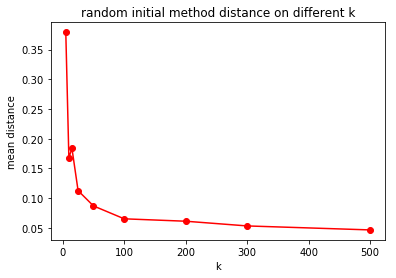

In [722]:
import matplotlib
import matplotlib.pyplot as plt
plt.title('random initial method distance on different k')
plt.xlabel('k')
plt.ylabel('mean distance')
x =[5,10,15,25,50,100,200,300,500]
y = np.mean(dmatrix_random,axis=1)
plt.plot(x,y,'ro-')
plt.show()

In [723]:
np.mean(dmatrix_random,axis=1)

array([ 0.37928769,  0.16785418,  0.18385494,  0.1126697 ,  0.08700003,
        0.06528206,  0.06122526,  0.05330125,  0.04659398])

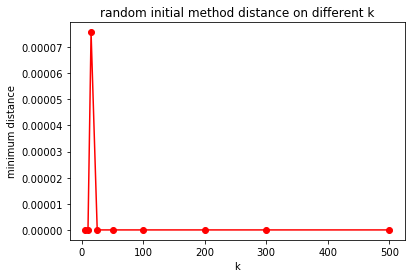

In [724]:
import matplotlib
import matplotlib.pyplot as plt
plt.title('random initial method distance on different k')
plt.xlabel('k')
plt.ylabel('minimum distance')
x = [5,10,15,25,50,100,200,300,500]
y = np.amin(dmatrix_random,axis=1)
plt.plot(x,y,'ro-')
plt.show()

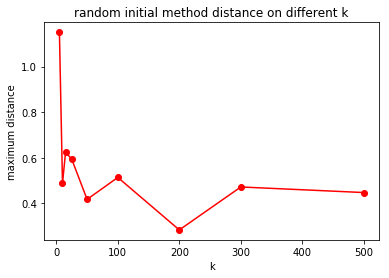

In [725]:
import matplotlib
import matplotlib.pyplot as plt
plt.title('random initial method distance on different k')
plt.xlabel('k')
plt.ylabel('maximum distance')
x = [5,10,15,25,50,100,200,300,500]
y = np.amax(dmatrix_random,axis=1)
plt.plot(x,y,'ro-')
plt.show()

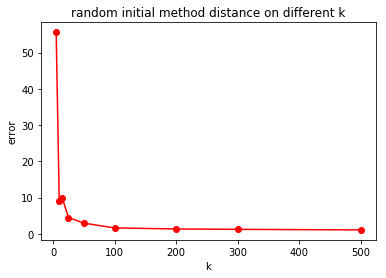

In [726]:
import matplotlib
import matplotlib.pyplot as plt
plt.title('random initial method distance on different k')
plt.xlabel('k')
plt.ylabel('error')
x = [5,10,15,25,50,100,200,300,500]
y = np.sum(dmatrix_random**2,axis=1)
plt.plot(x,y,'ro-')
plt.show()

In [727]:
np.sum(dmatrix_random**2,axis=1)

array([ 55.62447939,   9.02688642,   9.84669411,   4.48129507,
         2.94668113,   1.63348505,   1.34633592,   1.23592729,   1.0798377 ])

## Using random centroids initialization method, when k = 500, it has the lowest error 1.0798 (sum of points to centroids distance square). The error decreases when k increases.

In [748]:
def distance_mkk(X,k_range,m,B_size,T):
    d_matrix = np.zeros((len(k_range),B_size))
    for i in range(len(k_range)):
        k = k_range[i]
        # use K-MC^2 initialization method to generate centroids
        initial_cen = init_centroid_markov(X,m,k)
        f_cen = mini_batch(B_size,X,initial_cen,T)
        X_b_index = np.random.randint(X.shape[0], size=B_size)
        X_b = X[X_b_index,:]
        center_cluster = get_nearest_center(X_b,f_cen)
        d_matrix[i,:] = np.linalg.norm(X_b-center_cluster,axis=1)
    return d_matrix

In [749]:
kkk = [5,10,15,25,50,100,200,300,500]
import time
t0 = time.time()
dmatrix_mkk = distance_mkk(matrix,kkk,20,200,1000)
elapsed = (time.time() - t0)

In [750]:
elapsed

1004.6887009143829

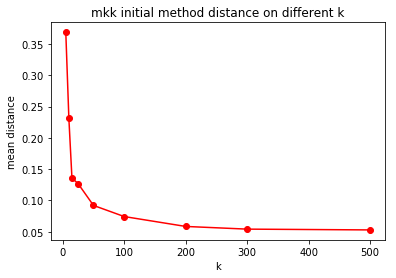

In [751]:
import matplotlib
import matplotlib.pyplot as plt
plt.title('mkk initial method distance on different k')
plt.xlabel('k')
plt.ylabel('mean distance')
x = [5,10,15,25,50,100,200,300,500]
y = np.mean(dmatrix_mkk,axis=1)
plt.plot(x,y,'ro-')
plt.show()

In [752]:
np.mean(dmatrix_mkk,axis=1)

array([ 0.36884134,  0.23115741,  0.13575981,  0.12680638,  0.09198619,
        0.07418839,  0.05837605,  0.05407824,  0.05282014])

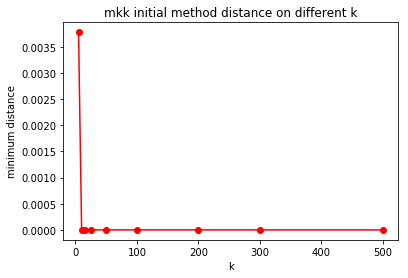

In [753]:
import matplotlib
import matplotlib.pyplot as plt
plt.title('mkk initial method distance on different k')
plt.xlabel('k')
plt.ylabel('minimum distance')
x = [5,10,15,25,50,100,200,300,500]
y = np.amin(dmatrix_mkk,axis=1)
plt.plot(x,y,'ro-')
plt.show()

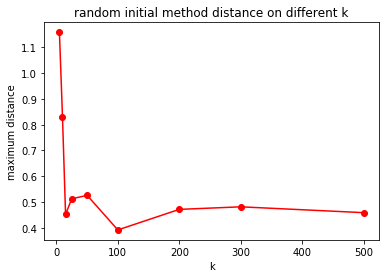

In [754]:
import matplotlib
import matplotlib.pyplot as plt
plt.title('random initial method distance on different k')
plt.xlabel('k')
plt.ylabel('maximum distance')
x = [5,10,15,25,50,100,200,300,500]
y = np.amax(dmatrix_mkk,axis=1)
plt.plot(x,y,'ro-')
plt.show()

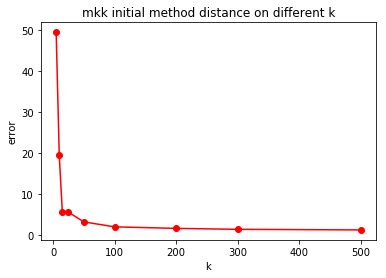

In [755]:
import matplotlib
import matplotlib.pyplot as plt
plt.title('mkk initial method distance on different k')
plt.xlabel('k')
plt.ylabel('error')
x = [5,10,15,25,50,100,200,300,500]
y1 = np.sum(dmatrix_mkk**2,axis=1)
plt.plot(x,y1,'ro-')
plt.show()

In [756]:
np.sum(dmatrix_mkk**2,axis=1)

array([ 49.41301834,  19.43250842,   5.59155925,   5.48819368,
         3.12304677,   1.91128354,   1.5397523 ,   1.30603541,   1.16320376])

## Using k-mc^2 centroids initialization method, when k = 500, it has the lowest error 1.1632 (sum of points to centroids distance square). The error decreases when k increases.

## compare performance between random and k-mc^2 initialize method

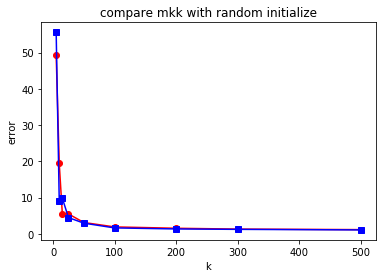

In [757]:
import matplotlib
import matplotlib.pyplot as plt
plt.title('compare mkk with random initialize')
plt.xlabel('k')
plt.ylabel('error')
x = [5,10,15,25,50,100,200,300,500]
y1 = np.sum(dmatrix_mkk**2,axis=1)
y2 = np.sum(dmatrix_random**2,axis=1)
plt.plot(x,y1,'ro-',x,y2,'bs-')
plt.show()

## Blue plot is randomized centroids, red plot is k-mc^2 randomized centroids. The performance of k-mc^2 centroids is better than randomized centroids. When k is around 20 and 50, it could be found that randomized centroids error is larger than k-mc^2 centroids error. After k=50, their performance are nearly the same.